In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
import matplotlib.pyplot as plt
import pandas
import numpy as np
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# Data Loader

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
def readFile2Dataframe(colpath, train_datapath, test_datapath=None):
    with open(colpath) as file:
        columns = [x.strip() for x in file.readline().split(',')]
        
    data = pandas.read_csv(train_datapath, sep=",", header=None, skipinitialspace=True, names=columns)
    
    if test_datapath is not None:
        train_data = data
        test_data = pandas.read_csv(test_datapath, sep=",", header=None, skipinitialspace=True, names=columns)
    else:
        train_data, test_data = train_test_split(data, test_size=0.33, random_state=219366)
        
    return train_data, test_data

In [5]:
def convertCategorical2Catcode(data, columns):
    data = data[columns].apply(lambda x: pandas.factorize(x)[0])
    return data

# Census Income

In [6]:
df_train, df_test = readFile2Dataframe("data/Census_Income/adult.colnames", "data/Census_Income/adult.data", "data/Census_Income/adult.test")

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  class           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [8]:
df_train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [9]:
df_train[["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "class"]] = convertCategorical2Catcode(df_train, ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "class"])
df_test[["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "class"]]  = convertCategorical2Catcode(df_test, ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "class"])

In [10]:
X_train = df_train.drop(columns=["class"])
y_train = df_train["class"]

X_test = df_test.drop(columns=["class"])
y_test = df_test["class"]

In [11]:
y_train

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: class, Length: 32561, dtype: int64

# Pipeline


In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import sqrt

from mlxtend.evaluate import mcnemar_table, paired_ttest_5x2cv

from sklearn.metrics import  accuracy_score, f1_score

### Confidence interval:

$$ a\pm t_{\alpha,k-1 }\frac{s}{\sqrt{k}} $$

Where:
 - $a$ is the average of the accuracies across the kfolds
 - $s$ is the variance of the accuracies across the kfolds
 - $k$ is the number of k_folds
 - $t_{\alpha,k-1 }$, is the t-score value - 2.262156, for a 95% confidence level




In [13]:
#plot confidence intervals following the t-score of the various models tested in the k-fold cross validation of the grid search
def plot_confidence_interval(mean, stdev, params, t = 2.262156, k = 10, horizontal_line_width=0.25):
    '''
    Plots different confidence intervals of various models tested in the k-folds cross validation grid search.


    :param mean: array containing the average scores of the different models
    :param stdev: array containing the standard deviations scores of the different models
    :param params: array of the parameters tested
    :param t: the t-score to generate the confidence interval around
    :param k: the number of folds executed
    :param horizontal_line_width: width of the horizontal line
    :return: None
    '''

    legend = []
    plt.figure(figsize=(13, 13))

    for i in range(1,len(mean)+1):
        color = np.random.rand(3,) #generate a color for each line

        confidence_interval =  t*((stdev[i-1]*100)**2 /sqrt(k-1)) #create the confidence interval

        left = i - horizontal_line_width / 2
        top = mean[i-1]*100 - confidence_interval
        right = i + horizontal_line_width / 2
        bottom = mean[i-1]*100 + confidence_interval

        #plot the lines
        plt.plot([i, i], [top, bottom], color=color)
        plt.plot([left, right], [top, top], color=color)
        plt.plot([left, right], [bottom, bottom], color=color)
        plt.plot(i, mean[i-1]*100, 'o', color=color)
        #add the parameters to the legend
        legend.append(mpatches.Patch(color = color, label=f"{i}: {params[i-1]}"))

    plt.xticks(range(1,len(mean)+1))
    plt.legend(handles=legend,bbox_to_anchor=(1.04,1), loc="upper left")
    plt.ylabel('Test F1 score')
    plt.xlabel('Test number')
    plt.title('Confidence Interval')
    plt.title('95% Confidence Interval of the cross validation of the grid search results')


### Pipeline

We use gridsearch to select the optimal model parameters for the model and dataset.

We use F1-Score as the main model metric, as it is generally better than the accuracy score, as we have some imbalanced datasets. We also use AUC score as a substitute for accuracy in this case as it uses probabilities of FPR and TPR.

In [14]:
def pipeline(X, y, model, param_grid, k = 10, t = 2.262156):
    scoring = {"AUC": "roc_auc", "F1": "f1"}

    gs = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring=scoring,
        refit="F1",
        return_train_score=True,
        n_jobs=-1,
        cv=k
    )

    print("=============================================================")
    print(f"MODEL: {type(model).__name__}")
    gs.fit(X, y)
    results = gs.cv_results_

    print("=============================================================")
    print(f"BEST PARAMETERS: {gs.best_params_}")
    print("=============================================================")
    print(f"BEST MODEL RESULTS:")
    print(f"MEAN TRAIN F1-SCORE: {results['mean_train_F1'][gs.best_index_]}")
    print(f"MEAN TRAIN AUC SCORE: {results['mean_train_AUC'][gs.best_index_]}")
    print(f"MEAN TEST F1-SCORE: {results['mean_test_F1'][gs.best_index_]}")
    print(f"MEAN TEST AUC SCORE: {results['mean_test_AUC'][gs.best_index_]}")
    confidence_interval =  t*((results['std_test_F1'][gs.best_index_]*100)**2 /sqrt(k-1))
    print(f"TEST F1-SCORE CONFIDENCE INTERVAL: {results['mean_test_F1'][gs.best_index_]*100-confidence_interval},{results['mean_test_F1'][gs.best_index_]*100+confidence_interval}")
    print("=============================================================")

    plot_confidence_interval(results['mean_test_F1'], results['std_test_F1'], results['params'], k=k, t =t)

    plt.show()

    return results, gs


### Model Evaluator

We then evaluate the best model picked by the grid search, and determine its accuracy and F1-score on train and test data, aswell as show its confidence intervals in accordance with a 95% z-score

In [15]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

def model_evaluator(model,X_train,y_train,X_test,y_test, z= 1.96, k=10,  t = 2.262156):
    '''
    Used to train and evaluate a model
    :param model: model to be evlauated
    :param X_train:
    :param y_train:
    :param X_test:
    :param y_test:
    :param z: Z-score to generate a confidence interval
    :return: The predicted values on the test set
    '''

    model2 = model



    print(f"Performing training for {k}-fold Cross Validation:")
    #train the model
    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])
    kf = KFold(n_splits=k)
    cv = cross_validate(model2,X,y, scoring=("f1", "accuracy") ,cv=k)

    stdev = np.std(cv['test_accuracy'])
    acc = np.mean(cv['test_accuracy'])*100
    confidence_interval =  t*((stdev*100)**2 /sqrt(k-1))
    print(f"CV ACCURACY:{acc:.3f} CONFIDENCE INTERVAL: {(acc-confidence_interval)},{(acc+confidence_interval)}")

    stdev = np.std(cv['test_f1'])
    f1 = np.mean(cv['test_f1'])*100
    confidence_interval =  t*((stdev*100)**2 /sqrt(k-1))
    print(f"CV F1-SCORE:{f1:.3f} CONFIDENCE INTERVAL: {(f1-confidence_interval)},{(f1+confidence_interval)}")




    print("Performing training for Holdout:")
    #train the model
    model.fit(X_train, y_train)
    #predict the test set
    y_pred = model.predict(X_test)
    #get the accuracy, although it is not the best metric
    acc = accuracy_score(y_test, y_pred)
    #generate the confidence interval
    confidence_interval =  z*sqrt(acc*(1-acc)/len(y_test))
    print(f"TEST ACCURACY:{acc*100:.3f} CONFIDENCE INTERVAL: {(acc-confidence_interval)*100},{(acc+confidence_interval)*100}")
    #get the f1-score
    f1 = f1_score(y_test, y_pred)
    confidence_interval =  z*sqrt(f1*(1-f1)/len(y_test))
    print(f"TEST F1-SCORE:{f1*100:.3f} CONFIDENCE INTERVAL: {(f1-confidence_interval)*100},{(f1+confidence_interval)*100}")




    return y_pred


### Compare Models

In [16]:
def model_comparer(model1, model2, X_train, y_train, X_test, y_test):
    '''
    Designeed to compare 2 models to identify if they are statistically similar
    :param model1: The first model
    :param model2: The second model
    :param X_test: The dataset to test on
    :param y_test: The scores to test the models on
    :return: None
    '''

    print("=============================================================")
    print(f"TRAINING MODEL 1: {type(model1).__name__}")
    model1.fit(X_train, y_train)
    print("=============================================================")
    print(f"TRAINING MODEL 2: {type(model2).__name__}")
    model2.fit(X_train, y_train)
    y_model1 = model1.predict(X_test)
    y_model2 = model2.predict(X_test)

    print("=============================================================")
    print(f"MODEL 1: {type(model1).__name__}, ACCURACY: {accuracy_score(y_test, y_model1)*100:.3f}, F1-SCORE: {f1_score(y_test, y_model1)*100:.3f}")
    print(f"MODEL 2: {type(model2).__name__}, ACCURACY: {accuracy_score(y_test, y_model2)*100:.3f}, F1-SCORE: {f1_score(y_test, y_model2)*100:.3f}")
    print("=============================================================")
    print("MCNEMAR TABLE:")

    mc_table = mcnemar_table(y_test, y_model1, y_model2)

    labels = ["Predicted Correct", "Predicted Incorrect"]
    ax = sns.heatmap(mc_table, annot=True,fmt='g', yticklabels = labels, xticklabels=labels)
    ax.set(xlabel=type(model2).__name__, ylabel=type(model1).__name__, title="McNemar Table" )
    ax.set()
    plt.show()

    chisq = (mc_table[0][1] - mc_table[1,0])**2/(mc_table[0][1]+mc_table[1][0])

    print(mc_table)
    print("=============================================================")
    print(f"CHI-SQUARED TEST OF MCNEMAR TABLE: {chisq:.3f}")
    if chisq>3.841:
        print("Since the Chi-Square is above the threshhold of 3.841, we reject the null hypothesis, showing the models are significantly different.")
    else:
        print("Since the Chi-Square is above the threshhold of 3.841, we accept the null hypothesis, showing the models are similar.")
    print("=============================================================")
    print("5x2 CV PAIRED T-TEST:")
    print("=============================================================")

    paired_tttest1 = paired_ttest_5x2cv(model1, model2, X_train, y_train, scoring=None, random_seed = 12345678)
    print(f"USING ACCURACY SCORE: T:{paired_tttest1[0]:.3f} P:{paired_tttest1[1]:.3f}")
    if paired_tttest1[1]<0.05:
        print("Since the P-test is below the threshhold of 0.05, we reject the null hypothesis, showing the models are significantly different.")
    else:
        print("Since the P-test is above the threshhold of 0.05, we accept the null hypothesis, showing the models are similar.")
    paired_tttest2 = paired_ttest_5x2cv(model1, model2, X_train, y_train, scoring="f1", random_seed = 12345678)
    print(f"USING F1-SCORE: T:{paired_tttest2[0]:.3f} P:{paired_tttest2[1]:.3f}")
    if paired_tttest2[1]<0.05:
        print("Since the P-test is below the threshhold of 0.05, we reject the null hypothesis, showing the models are significantly different.")
    else:
        print("Since the P-test is above the threshhold of 0.05, we accept the null hypothesis, showing the models are similar.")
    print("=============================================================")





    return

## Model Fitting - KNN

In [17]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

MODEL: KNeighborsClassifier
BEST PARAMETERS: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
BEST MODEL RESULTS:
MEAN TRAIN F1-SCORE: 0.37096557554422294
MEAN TRAIN AUC SCORE: 0.7770346546279057
MEAN TEST F1-SCORE: 0.349619347378928
MEAN TEST AUC SCORE: 0.6841162015826211
TEST F1-SCORE CONFIDENCE INTERVAL: 34.253479891061694,35.670389584723914


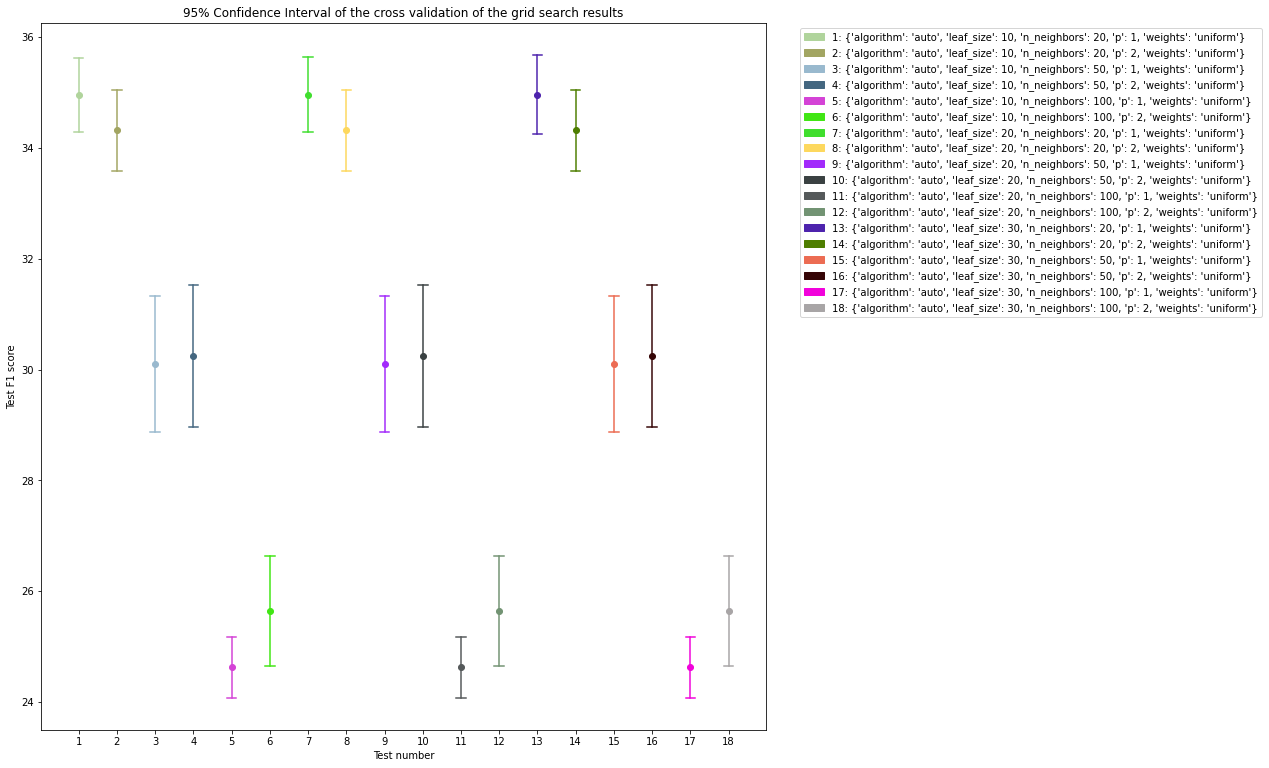

In [18]:

from sklearn.neighbors import KNeighborsClassifier

#todo add more paramaeters
param_grid = [
    {'p': [1,2],                       # p = 1 use manhattan_distance power parameter for Minkowski metric
    'n_neighbors': [20,50,100],
    'leaf_size':[10,20,30],
    'weights': ['uniform'],
    'algorithm':['auto']},
 ]

neigh = KNeighborsClassifier()


results, gs_neigh = pipeline(X, y, neigh, param_grid)

In [19]:
#create a model with the optimal paarameters
neigh = KNeighborsClassifier(**gs_neigh.best_params_)
#evaluate the model
neigh_y_pred = model_evaluator(neigh, X_train,y_train,X_test, y_test)

Performing training for 10-fold Cross Validation:
CV ACCURACY:80.244 CONFIDENCE INTERVAL: 80.2056054302564,80.28332548446777
CV F1-SCORE:34.962 CONFIDENCE INTERVAL: 34.253479891061694,35.670389584723914
Performing training for Holdout:
TEST ACCURACY:80.376 CONFIDENCE INTERVAL: 79.76583716856257,80.98595940412953
TEST F1-SCORE:33.312 CONFIDENCE INTERVAL: 32.58845641151468,34.036465316725774


## Model Fitting - XGBoost

MODEL: XGBClassifier
BEST PARAMETERS: {'colsample_bytree': 0.5, 'gamma': 3, 'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 10, 'reg_lambda': 1, 'subsample': 0.5}
BEST MODEL RESULTS:
MEAN TRAIN F1-SCORE: 0.7505869797972523
MEAN TRAIN AUC SCORE: 0.9458350390154113
MEAN TEST F1-SCORE: 0.6963232869338921
MEAN TEST AUC SCORE: 0.9207803602191227
TEST F1-SCORE CONFIDENCE INTERVAL: 68.98726611302304,70.27739127375538


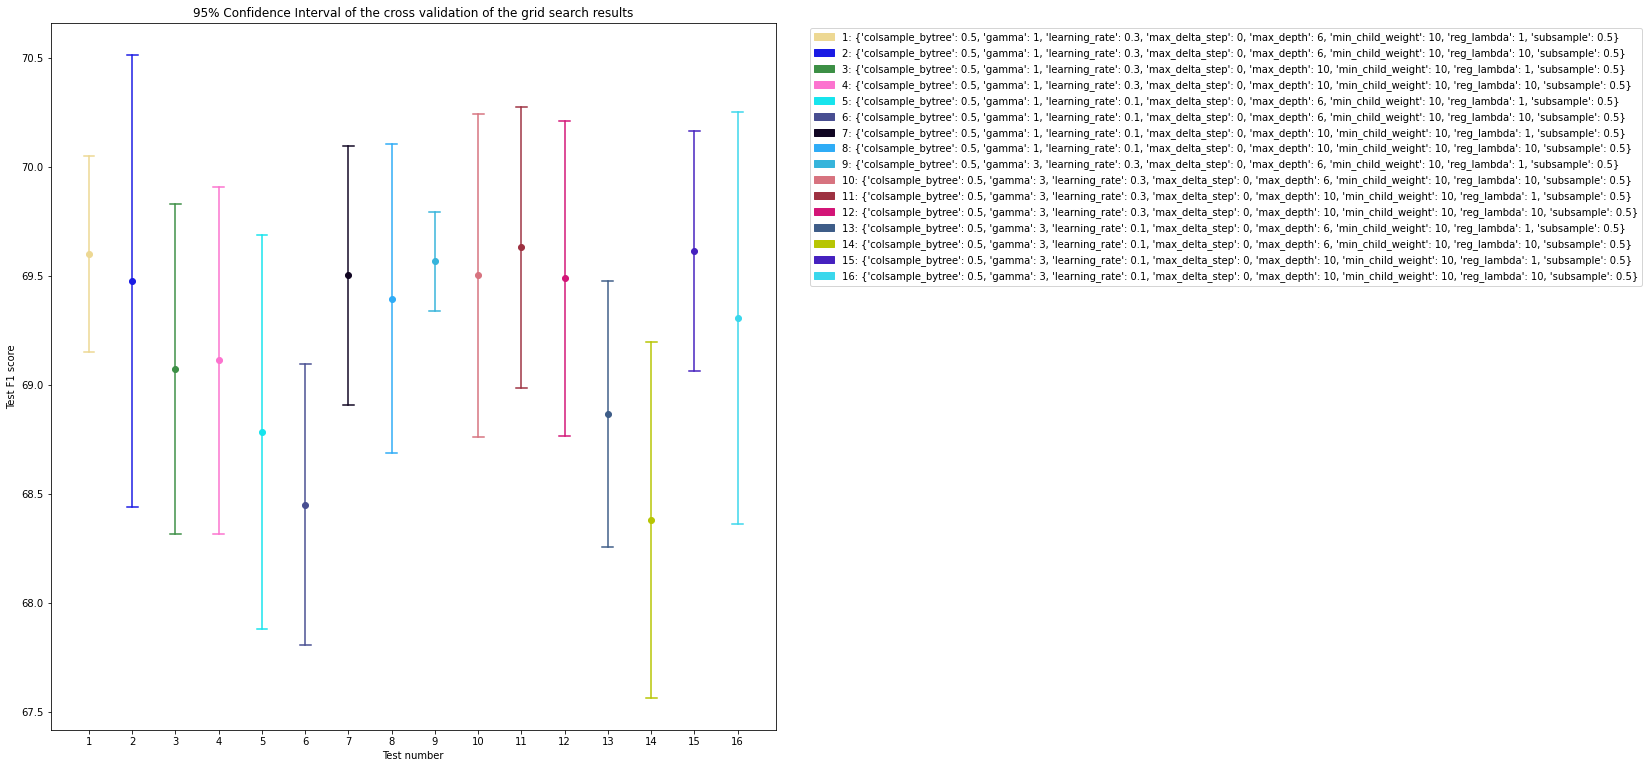

In [20]:
import xgboost as xgb

#todo add more paramaeters
# param_grid = {
#     "learning_rate": [0,1]," 
#     "max_depth": [6, 10],
#     "learning_rate": [0.5, 0.3, 0.1],
#     "gamma": [1, 3],
#     # "reg_lambda": [0, 1, 10], def 1, pref 10
#     "scale_pos_weight": [1, 3, 5], #proportion of negative/positive
#     "subsample": [0.5],
#     "colsample_bytree": [0.5],
#     "scale_pos_weight": [1,3],  #proportion of negative/positive
# }

param_grid = {
    "learning_rate": [0,1],     # shrinks the features weights to prevent overfitting
    "max_depth": [6,10],        #depth of the tree, increases complexity of the model
    "learning_rate": [0.3,0.1],
    "gamma": [1,3],             #minimum loss required to split the tree
    "reg_lambda": [1,10],       #l2 reg weights
    "subsample": [0.5],         #proportion to subsample the train data
    "colsample_bytree": [0.5],
    "min_child_weight":[10],
    "max_delta_step":[0]
}


xgb_cl = xgb.XGBClassifier()


results, xgb_gs = pipeline(X, y, xgb_cl, param_grid)

In [21]:
#create a model with the optimal paarameters
xgb_cl = xgb.XGBClassifier(**xgb_gs.best_params_)
#evaluate the model
xgb_y_pred = model_evaluator(xgb_cl, X_train,y_train,X_test, y_test)



Performing training for 10-fold Cross Validation:
CV ACCURACY:86.628 CONFIDENCE INTERVAL: 86.5287673985218,86.72786152033844
CV F1-SCORE:69.632 CONFIDENCE INTERVAL: 68.98726611302304,70.27739127375538
Performing training for Holdout:
TEST ACCURACY:83.109 CONFIDENCE INTERVAL: 82.53361856611231,83.68467269363832
TEST F1-SCORE:56.597 CONFIDENCE INTERVAL: 55.83589413167278,57.35855031277166


TRAINING MODEL 1: XGBClassifier
TRAINING MODEL 2: KNeighborsClassifier
MODEL 1: XGBClassifier, ACCURACY: 83.109, F1-SCORE: 56.597
MODEL 2: KNeighborsClassifier, ACCURACY: 80.376, F1-SCORE: 33.312
MCNEMAR TABLE:


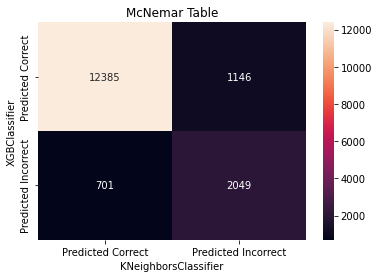

[[12385  1146]
 [  701  2049]]
CHI-SQUARED TEST OF MCNEMAR TABLE: 107.214
Since the Chi-Square is above the threshhold of 3.841, we reject the null hypothesis, showing the models are significantly different.
5x2 CV PAIRED T-TEST:
USING ACCURACY SCORE: T:32.036 P:0.000
Since the P-test is below the threshhold of 0.05, we reject the null hypothesis, showing the models are significantly different.
USING F1-SCORE: T:34.702 P:0.000
Since the P-test is below the threshhold of 0.05, we reject the null hypothesis, showing the models are significantly different.


In [22]:
model_comparer(xgb_cl, neigh, X_train, y_train , X_test, y_test)

## Model Fitting ADABoost

MODEL: AdaBoostClassifier
BEST PARAMETERS: {'n_estimators': 500}
BEST MODEL RESULTS:
MEAN TRAIN F1-SCORE: 0.6886846997794793
MEAN TRAIN AUC SCORE: 0.9250933069213829
MEAN TEST F1-SCORE: 0.6814409183850731
MEAN TEST AUC SCORE: 0.9215958228243023
TEST F1-SCORE CONFIDENCE INTERVAL: 66.98243957324829,69.30574410376633


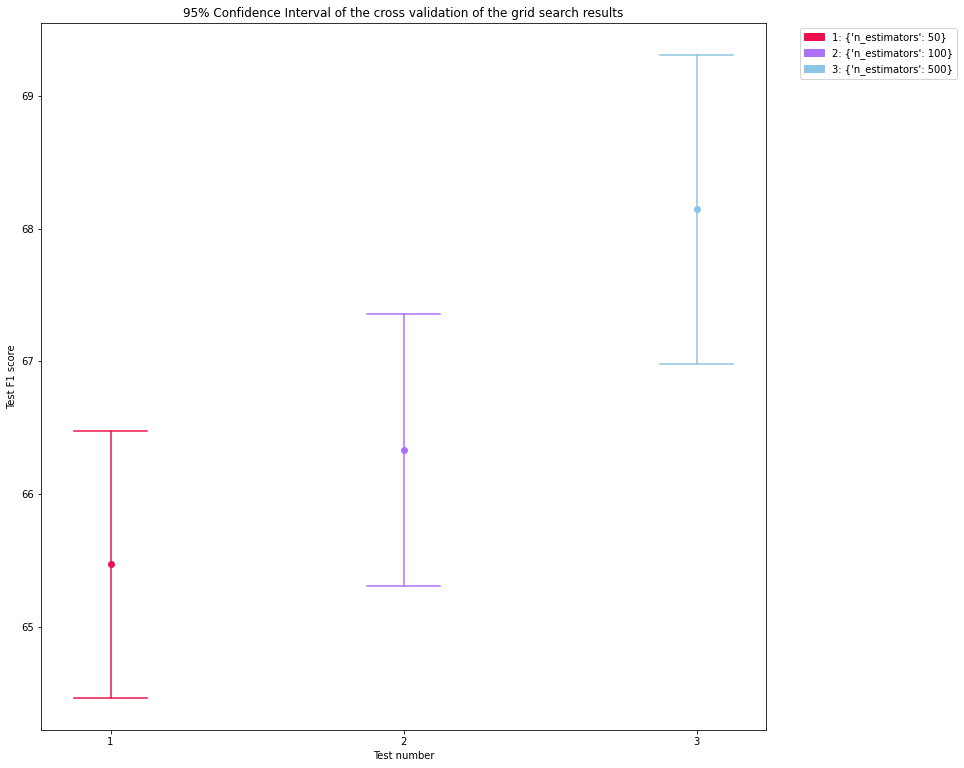

In [23]:
from sklearn.ensemble import AdaBoostClassifier

AdaBoostClassifier


param_grid = {
    "n_estimators":[50,100,500]
}


ada_cl = AdaBoostClassifier()


results, ada_gs = pipeline(X, y, ada_cl, param_grid)


In [24]:
#create a model with the optimal paarameters
ada_cl = AdaBoostClassifier(**ada_gs.best_params_)
#evaluate the model
ada_y_pred = model_evaluator(ada_cl, X_train,y_train,X_test, y_test)



Performing training for 10-fold Cross Validation:
CV ACCURACY:86.483 CONFIDENCE INTERVAL: 86.35242373213795,86.61347414675892
CV F1-SCORE:68.144 CONFIDENCE INTERVAL: 66.98243957324829,69.30574410376633
Performing training for Holdout:
TEST ACCURACY:85.210 CONFIDENCE INTERVAL: 84.66443813894561,85.75506926231967
TEST F1-SCORE:63.124 CONFIDENCE INTERVAL: 62.38292961353825,63.865156144501555


TRAINING MODEL 1: AdaBoostClassifier
TRAINING MODEL 2: KNeighborsClassifier
MODEL 1: AdaBoostClassifier, ACCURACY: 85.210, F1-SCORE: 63.124
MODEL 2: KNeighborsClassifier, ACCURACY: 80.376, F1-SCORE: 33.312
MCNEMAR TABLE:


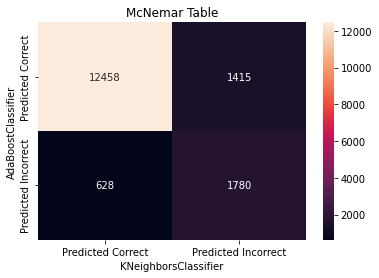

[[12458  1415]
 [  628  1780]]
CHI-SQUARED TEST OF MCNEMAR TABLE: 303.166
Since the Chi-Square is above the threshhold of 3.841, we reject the null hypothesis, showing the models are significantly different.
5x2 CV PAIRED T-TEST:
USING ACCURACY SCORE: T:31.391 P:0.000
Since the P-test is below the threshhold of 0.05, we reject the null hypothesis, showing the models are significantly different.
USING F1-SCORE: T:33.551 P:0.000
Since the P-test is below the threshhold of 0.05, we reject the null hypothesis, showing the models are significantly different.


In [25]:
model_comparer(ada_cl, neigh, X_train, y_train, X_test, y_test)

TRAINING MODEL 1: XGBClassifier
TRAINING MODEL 2: AdaBoostClassifier
MODEL 1: XGBClassifier, ACCURACY: 83.109, F1-SCORE: 56.597
MODEL 2: AdaBoostClassifier, ACCURACY: 85.210, F1-SCORE: 63.124
MCNEMAR TABLE:


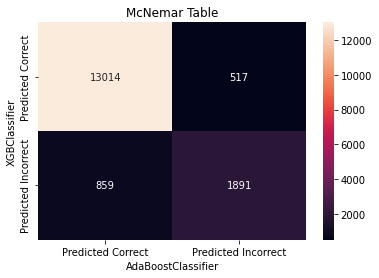

[[13014   517]
 [  859  1891]]
CHI-SQUARED TEST OF MCNEMAR TABLE: 85.003
Since the Chi-Square is above the threshhold of 3.841, we reject the null hypothesis, showing the models are significantly different.
5x2 CV PAIRED T-TEST:
USING ACCURACY SCORE: T:-6.665 P:0.001
Since the P-test is below the threshhold of 0.05, we reject the null hypothesis, showing the models are significantly different.
USING F1-SCORE: T:-5.446 P:0.003
Since the P-test is below the threshhold of 0.05, we reject the null hypothesis, showing the models are significantly different.


In [26]:
model_comparer(xgb_cl, ada_cl, X_train, y_train, X_test, y_test)

# Conclusion

- All three of the models are significantly worse on the f1-score than accuracy scores.
- f1 score, adaboost is similar to xgboost, and there is no significant difference between the models. 
- When comparing accuracy however, Adaboost is better by slight margin. 
- When comparing them to KNN, they are both signifcantly better in f1-score, and accuracy.
- We compared the models in pairs (XG, KNN), (Ada, KNN), (XG, Ada) using CHI-SQUARED and 5x2 CV PAIRED test and found that model pairs are significantly different.

